In [1]:
from audio_dataset import MelSpectrogramDataset,denormalize

from pathlib import Path

import os

import numpy as np
import pandas as pd

import librosa
import librosa.display

import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torchvision.models as torch_models
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from fastai.vision.all import *

In [2]:
root = '/home/heye0507/sz_audio'
audio_data = root + '/audio_data'
data = root + '/data'

In [3]:
df_train = pd.read_csv(data+'/train.csv')
df_valid = pd.read_csv(data+'/valid_test.csv')
df_valid = df_valid[df_valid['valid']==True]

In [4]:
def get_train_transform():
    return A.Compose([
        #A.HorizontalFlip(p=0.5),
        #A.VerticalFlip(p=0.5),
        #A.Resize(height=512,width=512,p=1.0),
        A.Normalize(p=1.0),
        ToTensorV2(p=1.0),
    ],p=1.0)

def get_valid_transform():
    return A.Compose([
        #A.Resize(height=512,width=512,p=1.0),
        A.Normalize(p=1.0),
        ToTensorV2(p=1.0),
    ],p=1.0)

In [5]:
train_ds = MelSpectrogramDataset(df_train,audio_data,img_tfms=get_train_transform())
valid_ds = MelSpectrogramDataset(df_valid,audio_data,img_tfms=get_valid_transform())

In [7]:
len(train_ds),len(valid_ds)

(394, 149)

In [6]:
#Mish - "Mish: A Self Regularized Non-Monotonic Neural Activation Function"
#https://arxiv.org/abs/1908.08681v1
#implemented for PyTorch / FastAI by lessw2020 
#github: https://github.com/lessw2020/mish
class Mish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        #inlining this saves 1 second per epoch (V100 GPU) vs having a temp x and then returning x(!)
        return x * (torch.tanh(F.softplus(x)))

In [7]:
class Model_Head(nn.Module):
    def __init__(self,ni,nc,ps=0.25):
        '''
        ni : input filter size
        nc : output class size
        ps : dropout rate
        '''
        super().__init__()
        layers = ([Mish(),ConvLayer(ni,ni,act_cls=None),AdaptiveConcatPool2d(),
                   Flatten(), LinBnDrop(ni*2,512,p=ps,act=Mish()), 
                   LinBnDrop(512,nc,p=ps*2)])
        self.head = nn.Sequential(*layers)
    
    def forward(self,xb):
        return self.head(xb)
    
class Resnet_audio(nn.Module):
    def __init__(self,arch,nc=[1,1,1],pretrained=True):
        super().__init__()
        self.body = nn.Sequential(*list(arch(pretrained=pretrained).children())[:-2])
       
        # change input filter size to 1
#         nf,ni,h,w = self.body[0].weight.shape
#         w = self.body[0].weight.sum(dim=1,keepdim=True)
#         conv_input = conv2d(1,nf,ks=h)
#         conv_input.weight.data = w
#         self.body[0] = conv_input
        
        # multi-head output
        # 1,1,1 regression head
        ni = num_features_model(self.body)
        self.head_tsh = Model_Head(ni,nc[0])
        self.head_t3 = Model_Head(ni,nc[1])
        self.head_t4 = Model_Head(ni,nc[2])
    
    def forward(self,x):
        x = self.body(x)
        return (self.head_tsh(x),self.head_t3(x),self.head_t4(x))
    
# replace all relu layer with Mish        
def to_mish(model):
    for name,child in model.named_children():
        if isinstance(child,nn.ReLU):
            setattr(model,name,Mish())
        else:
            to_mish(child)

In [31]:
model = Resnet_audio(torch_models.resnet34).cuda()

In [32]:
class Loss_multi_head(nn.Module):
    def __init__(self,weights=[1,1,1]):
        super().__init__()
        self.weights = weights
        
    def forward(self,preds,target):
        outp_tsh,outp_t3,outp_t4 = preds
        outp_tsh,outp_t3,outp_t4 = outp_tsh.float(),outp_t3.float(),outp_t4.float()
        targ_tsh,targ_t3,targ_t4 = target[0]
        return (
            self.weights[0] * F.mse_loss(outp_tsh.squeeze(),targ_tsh)
            + self.weights[1] * F.mse_loss(outp_t3.squeeze(),targ_t3)
            + self.weights[2] * F.mse_loss(outp_t4.squeeze(),targ_t4)
        )
        

In [10]:
def audio_mse(inp,targ):
    outp_tsh,outp_t3,outp_t4 = inp
    outp_tsh,outp_t3,outp_t4 = outp_tsh.float(),outp_t3.float(),outp_t4.float()
    targ_tsh,targ_t3,targ_t4 = targ[0]
    return torch.sqrt(
        F.mse_loss(outp_tsh.squeeze(),targ_tsh)
        + F.mse_loss(outp_t3.squeeze(),targ_t3)
        + F.mse_loss(outp_t4.squeeze(),targ_t4)
    )

In [11]:
loss_func = Loss_multi_head()

In [12]:
# train_loader = torch.utils.data.DataLoader(
#         train_ds,
#         sampler=RandomSampler(train_ds),
#         batch_size=32,
#         pin_memory=False,
#         drop_last=True,
#         num_workers=4,
#     )

# val_loader = torch.utils.data.DataLoader(
#         valid_ds, 
#         batch_size=32,
#         num_workers=4,
#         shuffle=False,
#         sampler=SequentialSampler(valid_ds),
#         pin_memory=False,
#     )

In [12]:
from fastai.data.core import DataLoaders

In [13]:
tr_dl = DataLoader(train_ds,batch_size=32,num_workers=4)
vl_dl = DataLoader(valid_ds,batch_size=32,num_workers=4)

In [14]:
dls = DataLoaders(tr_dl,vl_dl,device='cuda')

In [23]:
b = dls.one_batch()

In [24]:
b[0].shape,len(b[1])

(torch.Size([32, 3, 128, 235]), 2)

In [23]:
preds = model(b[0])

In [24]:
loss_func(preds,b[1])

tensor(153.1351, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)

In [25]:
audio_mse(preds,b[1])

tensor(12.3748, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)

In [33]:
learn = Learner(dls,model,loss_func=loss_func,metrics=audio_mse)

SuggestedLRs(lr_min=0.014454397559165954, lr_steep=6.309573450380412e-07)

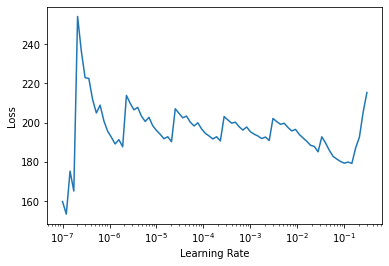

In [17]:
learn.lr_find()

In [34]:
learn.fit_one_cycle(50,1e-2)

epoch,train_loss,valid_loss,audio_mse,time
0,196.707611,224.768646,14.897846,00:13
1,194.825470,211.777832,14.478728,00:12
2,191.511642,127.667473,11.212392,00:12
3,187.480972,627.709656,24.236097,00:13
4,180.142975,88.701973,9.344132,00:13
5,167.232697,291.259277,16.874552,00:13
6,145.154129,15945.119141,125.419998,00:12
7,123.090874,1361642.625000,1162.854736,00:13
8,104.532257,34.767616,5.650154,00:13
9,90.573509,123.390755,10.486389,00:13


In [35]:
x,y = dls[1].one_batch()

In [36]:
preds = learn.model(x)

In [37]:
tsh,t3,t4 = preds

In [44]:
tsh,y[0][0]

(tensor([[1.2436],
         [1.4181],
         [1.9329],
         [1.8494],
         [1.4736],
         [1.3429],
         [1.4554],
         [1.4837],
         [1.8392],
         [2.2062],
         [1.9169],
         [2.6842],
         [1.4917],
         [1.8472],
         [1.3496],
         [1.3458],
         [1.3433],
         [1.4934],
         [1.4228],
         [1.4836],
         [1.3963],
         [1.8837],
         [1.8507],
         [1.7814],
         [2.1218],
         [1.2829],
         [1.5034],
         [1.3984],
         [1.3170],
         [1.7331],
         [1.7746],
         [1.7291]], device='cuda:0', grad_fn=<MmBackward>),
 tensor([0.6700, 0.6700, 0.6700, 0.6700, 0.7000, 0.7000, 0.7000, 0.7000, 2.7600,
         2.7600, 2.7600, 2.7600, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000,
         3.5000, 3.5000, 2.2900, 2.2900, 2.2900, 2.2900, 2.5200, 2.5200, 2.5200,
         2.5200, 2.5200, 2.5200, 5.4300, 5.4300], device='cuda:0'))

In [42]:
t3,y[0][1]

(tensor([[5.6574],
         [5.4578],
         [3.6344],
         [5.2663],
         [5.7792],
         [5.5447],
         [5.3717],
         [5.3006],
         [5.5660],
         [5.1978],
         [5.5927],
         [4.9649],
         [5.4404],
         [5.1844],
         [5.6030],
         [5.8004],
         [5.5914],
         [5.2650],
         [5.5925],
         [5.4910],
         [5.7831],
         [5.4668],
         [5.3051],
         [5.2815],
         [4.3280],
         [5.9656],
         [5.3520],
         [5.2917],
         [5.8189],
         [4.8220],
         [5.2299],
         [5.2437]], device='cuda:0', grad_fn=<MmBackward>),
 tensor([2.7000, 2.7000, 2.7000, 2.7000, 5.5000, 5.5000, 5.5000, 5.5000, 4.5000,
         4.5000, 4.5000, 4.5000, 2.4200, 2.4200, 2.4200, 2.4200, 2.4200, 2.4200,
         2.4200, 2.4200, 4.6000, 4.6000, 4.6000, 4.6000, 3.0000, 3.0000, 3.0000,
         3.0000, 3.0000, 3.0000, 4.3000, 4.3000], device='cuda:0'))

In [43]:
t4,y[0][2]

(tensor([[11.1727],
         [ 9.4638],
         [ 9.2179],
         [11.7881],
         [12.7514],
         [ 9.3125],
         [11.2075],
         [12.1642],
         [ 9.6350],
         [ 9.1780],
         [ 9.4949],
         [ 9.0332],
         [10.7885],
         [11.4261],
         [ 9.8955],
         [12.0727],
         [ 9.2565],
         [10.6760],
         [ 9.2917],
         [ 9.7063],
         [11.3590],
         [10.3341],
         [10.9415],
         [10.2577],
         [ 8.9215],
         [14.0996],
         [10.5595],
         [ 8.1125],
         [15.6838],
         [11.1287],
         [10.2361],
         [10.1106]], device='cuda:0', grad_fn=<MmBackward>),
 tensor([13.7200, 13.7200, 13.7200, 13.7200, 11.9100, 11.9100, 11.9100, 11.9100,
         11.2200, 11.2200, 11.2200, 11.2200, 10.2200, 10.2200, 10.2200, 10.2200,
         10.2200, 10.2200, 10.2200, 10.2200, 13.1600, 13.1600, 13.1600, 13.1600,
         15.4900, 15.4900, 15.4900, 15.4900, 15.4900, 15.4900,  7.8300,  7.8